In [48]:
!pip install NREL-PySAM
!pip install pvlib

In [49]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import parameters
import pvlib
from pvlib import pvsystem

In [50]:
# Import the particular module of the pvlib library
from pvlib import pvsystem

# CEC PV Module Database
cec_mod_db = pvsystem.retrieve_sam('CECmod')

# Size of the database
print(cec_mod_db.shape)

#inverter Database
invdb = pvsystem.retrieve_sam('CECInverter')
print(invdb.shape)

(25, 21535)
(16, 3264)


In [51]:
# Accessing the characteristics of one of the modules randomly
print(cec_mod_db.iloc[:, np.random.randint(0, high=len(cec_mod_db))])

Technology           Multi-c-Si
Bifacial                      0
STC                     219.876
PTC                       189.1
A_c                       1.624
Length                    1.632
Width                     0.995
N_s                          60
I_sc_ref                   7.95
V_oc_ref                  36.06
I_mp_ref                    7.3
V_mp_ref                  30.12
alpha_sc               0.004357
beta_oc               -0.130681
T_NOCT                     50.2
a_ref                  1.673094
I_L_ref                7.959062
I_o_ref                     0.0
R_s                    0.140393
R_sh_ref             123.168404
Adjust                21.875164
gamma_r                 -0.5196
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Ablytek_6PN6A220_A0, dtype: object


In [52]:
# PV module data from a typical datasheet (e.g. Kyocera Solar KD225GX LPB)
module_data = {'celltype': 'multiSi', # technology
               'STC': 224.99, # STC power
               'PTC': 203.3, # PTC power
               'v_mp': 29.8, # Maximum power voltage
               'i_mp': 7.55, # Maximum power current
               'v_oc': 36.9, # Open-circuit voltage
               'i_sc': 8.18, # Short-circuit current
               'alpha_sc': 0.001636, # Temperature Coeff. Short Circuit Current [A/C]
               'beta_voc': -0.12177, # Temperature Coeff. Open Circuit Voltage [V/C]
               'gamma_pmp': -0.43, # Temperature coefficient of power at maximum point [%/C]
               'cells_in_series': 60, # Number of cells in series
               'temp_ref': 25}  # Reference temperature conditions

In [53]:
# Accessing the characteristics of one of the Inverters randomly
inverter_data = invdb.iloc[:, np.random.randint(0, high=len(invdb))]

print(inverter_data)

Vac                          240
Pso                    16.880829
Paco                      3000.0
Pdco                 3121.669922
Vdco                       340.0
C0                     -0.000006
C1                     -0.000021
C2                      0.000582
C3                     -0.000712
Pnt                          0.1
Vdcmax                     480.0
Idcmax                  9.181382
Mppt_low                   100.0
Mppt_high                  480.0
CEC_Date              10/15/2018
CEC_Type     Utility Interactive
Name: ABB__PVI_3_0_OUTD_S_US_A__240V_, dtype: object


In [54]:
#IV Characteristic Curve

# 1st step: Estimating the parameters for the CEC single diode model
""" WARNING - This function relies on NREL's SAM tool. So PySAM, its Python API, needs to be installed 
in the same computer. Otherwise, you can expect the following error: 'ImportError if NREL-PySAM is not installed.'
"""
cec_fit_params = pvlib.ivtools.sdm.fit_cec_sam(module_data['celltype'], module_data['v_mp'], module_data['i_mp'],
                                  module_data['v_oc'], module_data['i_sc'], module_data['alpha_sc'],
                                  module_data['beta_voc'], module_data['gamma_pmp'], 
                                  module_data['cells_in_series'], module_data['temp_ref'])

# Effective irradiance values (W/m2)
irrad = np.array([200,400,600,800,1000])
# Average cell temperature (degrees Celsius)
temp_cell = np.array([40, 40, 40, 40, 40])

# 2nd step: Apply model to estimate the 5 parameters of the single diode equation using the CEC model
diode_params = pvlib.pvsystem.calcparams_cec(irrad, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])

# The result of the function returns a Tuple of 5 parameters to be used in the single diode equation

# Estimate I-V characteristic using the Single Diode Equation
iv_values1 = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   # Number of points of the I-V curve (equally distributed)
                                        method='lambertw') # I-V using the Lambert W. function

# The result is a large ordered dictionary with the IV-curve characteristics of our example.
print(iv_values1.keys())


odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])


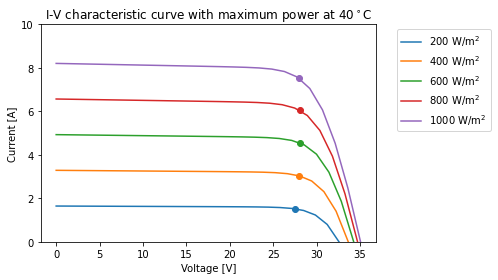

In [55]:
# We iterate over voltage
for i in range(len(irrad)):
    plt.plot(iv_values1['v'][i], iv_values1['i'][i], label=str(irrad[i])+' W/m$^2$')
    plt.scatter(iv_values1['v_mp'][i], iv_values1['i_mp'][i])
# Add the title, axis labels and legend: 
plt.title('I-V characteristic curve with maximum power at 40$^\circ$C')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.ylim(0, 10)
plt.legend(bbox_to_anchor=(1.05, 1), ncol=1)

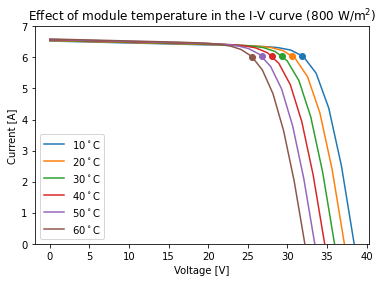

In [56]:
# Effective irradiance values (W/m2)
irrad = np.array([800, 800, 800, 800, 800, 800])
# Average cell temperature (degrees Celsius)
temp_cell = np.array([10, 20, 30, 40, 50, 60])

# Repeating the process from before:
# Estimate the 5 parameters of the single diode equation using the CEC model
diode_params = pvlib.pvsystem.calcparams_cec(irrad, temp_cell, module_data['alpha_sc'], cec_fit_params[4], 
                                            cec_fit_params[0], cec_fit_params[1], cec_fit_params[3], 
                                            cec_fit_params[2], cec_fit_params[5])

# Estimate I-V characteristic using the Single Diode Equation
iv_values2 = pvlib.pvsystem.singlediode(diode_params[0], 
                                        diode_params[1], 
                                        diode_params[2], 
                                        diode_params[3], 
                                        diode_params[4], 
                                        ivcurve_pnts=25,   # Number of points of the I-V curve (equally distributed)
                                        method='lambertw') # I-V using the Lambert W. function

# Plotting the results
for i in range(len(irrad)):
    plt.plot(iv_values2['v'][i], iv_values2['i'][i], label=str(temp_cell[i])+'$^\circ$C')
    plt.scatter(iv_values2['v_mp'][i], iv_values2['i_mp'][i])
# Add the title, axis labels and legend: 
plt.title('Effect of module temperature in the I-V curve (800 W/m$^2$)')
plt.xlabel('Voltage [V]')
plt.ylabel('Current [A]')
plt.ylim(0, 7)
plt.legend(ncol=1)

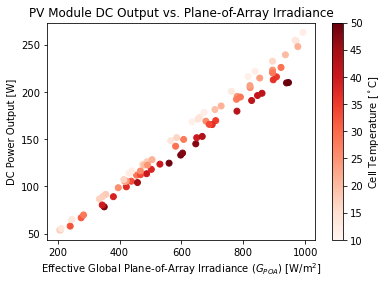

In [57]:
#3 Irradiance to DC power conversion ¶
# Randomly define a set of Effective Irradiance and cell temperature values:

# Global plane-of-array effective irradiance between 200 and 1000 W/m2
g_poa_effective = np.random.uniform(low=200, high=1000, size=(80,))
# Mean cell temperature values between 10 and 50 degrees Celsius
temp_cell = np.random.uniform(low=10, high=50, size=(80,)) 

# Definition of PV module characteristics:
pdc0 = 250 # STC power
gamma_pdc = -0.0045 # The temperature coefficient in units of 1/C

# Estimate DC power with PVWatts model
dc_power = pvlib.pvsystem.pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)

# Let's visualize the DC power output as function of the effective irradiance
plt.scatter(g_poa_effective, dc_power, c=temp_cell, vmin=10, vmax=50, cmap='Reds')
cbar = plt.colorbar()
cbar.set_label('Cell Temperature [$^\circ$C]')
plt.title('PV Module DC Output vs. Plane-of-Array Irradiance')
plt.xlabel('Effective Global Plane-of-Array Irradiance ($G_{POA}$) [W/m$^2$]')
plt.ylabel('DC Power Output [W]')
plt.show()

In [58]:
#DC to AC Power Conversion

# The DataFrame with the technical characteristics of the PV inverter
inverter_data.keys()

# The dictionary with the current and voltage values
iv_values1.keys()

odict_keys(['i_sc', 'v_oc', 'i_mp', 'v_mp', 'p_mp', 'i_x', 'i_xx', 'v', 'i'])

In [59]:
# Estimate AC power from DC power using the Sandia Model
ac_power = pvlib.inverter.sandia(iv_values1['v_mp'], # DC voltage input to the inverter
                                 iv_values1['p_mp'], # DC power input to the inverter
                                 inverter_data) # Parameters for the inverter 
# Estimated Power Output
ac_power

array([ 27.34323466,  69.68477695, 111.56288916, 152.57455746,
       192.53524642])

In [117]:
#Irradiance to Power Conversion
# Let's read the weather data from NREL Weather station https://midcdmz.nrel.gov/apps/data_api_doc.pl?_idtextlist

df_weather = pvlib.iotools.read_midc_raw_data_from_nrel('UOSMRL',               # Station id(cal poly) 
                                                    pd.Timestamp('20210101'),   # Start date YYYYMMDD
                                                    pd.Timestamp('20210131'))   # End date  YYYYMMDD

# Let's see the head, shape and columns of the data
df_weather.head(3)


,Unnamed: 0,Year,DOY,PST,Unnamed: 4,Direct NIP [W/m^2],Diffuse Schenk [W/m^2],Global LI-200 [W/m^2],Relative Humidity [%],Air Temperature [deg C],...,CHP1 Temp [deg K],CMP22 Temp [deg K],Avg Wind Direction @ 10m [deg from N],Zenith Angle [degrees],Azimuth Angle [degrees],Airmass,Solar Eclipse Shading,Direct SAMPA/Bird (calc) [W/m^2],Global SAMPA/Bird (calc) [W/m^2],Diffuse SAMPA/Bird (calc) [W/m^2]
2021-01-01 00:00:00-08:00,0,2021,1,0,-0.002,0.000,-1.057,0.017,80.8,9.05,...,282.0,283.2,131.4,158.67385,349.90342,-1.0,0,0.0,0.0,0.0
2021-01-01 00:01:00-08:00,0,2021,1,1,0.002,0.123,-1.039,0.030,80.6,9.09,...,281.9,283.2,149.0,158.70431,350.53096,-1.0,0,0.0,0.0,0.0
2021-01-01 00:02:00-08:00,0,2021,1,2,0.005,0.181,-1.041,0.028,80.3,9.10,...,281.9,283.2,150.8,158.73283,351.16003,-1.0,0,0.0,0.0,0.0


In [118]:
df_weather = df_weather[['Global CMP22 [W/m^2]', 'Diffuse Schenk [W/m^2]', 
                         'Direct CHP1 [W/m^2]','Air Temperature [deg C]', 'Avg Wind Speed @ 10m [m/s]']]
# Rename the columns
df_weather.columns = ['ghi', 'dhi', 'dni', 'temp_air', 'wind_speed']
# See the first columns of our weather dataset

df_weather.head(3)

,ghi,dhi,dni,temp_air,wind_speed
2021-01-01 00:00:00-08:00,-0.236,-1.057,0.071,9.05,1.450
2021-01-01 00:01:00-08:00,-0.217,-1.039,0.170,9.09,1.675
2021-01-01 00:02:00-08:00,-0.183,-1.041,0.114,9.10,2.000


In [135]:
#DEFINING CHARACTERISTICS OF PV SYSTEM

# Coordinates 
latitude = 44.0467
longitude = -123.0743
altitude = 133.8

# Define the location object
location = pvlib.location.Location(latitude, longitude, altitude=altitude)

# Define Temperature Paremeters 
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# Define the PV Module and the Inverter from the CEC databases (random)
module_data = cec_mod_db.iloc[:,0]
inverter_data = invdb.iloc[:, np.random.randint(0, high=len(invdb))]

# Define the basics of the class PVSystem
system = pvlib.pvsystem.PVSystem(surface_tilt=30, surface_azimuth=180,
                                 module_parameters=module_data,
                                 inverter_parameters=inverter_data,
                                 temperature_model_parameters=temperature_model_parameters)

# Creation of the ModelChain object
""" The example does not consider AOI losses nor irradiance spectral losses"""
mc = pvlib.modelchain.ModelChain(system, location, 
                                 aoi_model='no_loss', 
                                 spectral_model='no_loss',
                                 name='AssessingSolar_PV')

# Pass the weather data to the model
""" 
The weather DataFrame must include the irradiance components with the names 'dni', 'ghi', and 'dhi'. 
The air temperature named 'temp_air' in degree Celsius and wind speed 'wind_speed' in m/s are optional.
"""
mc.run_model(df_weather) 

C:\Users\baron\anaconda3\envs\microgrid\lib\site-packages\pvlib\tools.py:340: RuntimeWarning: divide by zero encountered in true_divide
  np.trunc(np.log(atol / (df['VH'] - df['VL'])) / np.log(phim1)))


ModelChain: 
  name: AssessingSolar_PV
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

In [136]:
mc.results.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2021-01-01 00:00:00-08:00,-0.003952,0.0,-0.003952,0.0,-0.003952
2021-01-01 00:01:00-08:00,-0.003634,0.0,-0.003634,0.0,-0.003634
2021-01-01 00:02:00-08:00,-0.003065,0.0,-0.003065,0.0,-0.003065
2021-01-01 00:03:00-08:00,-0.002880,0.0,-0.002880,0.0,-0.002880
2021-01-01 00:04:00-08:00,-0.002880,0.0,-0.002880,0.0,-0.002880
...,...,...,...,...,...
2021-01-31 23:55:00-08:00,-0.002864,0.0,-0.002864,0.0,-0.002864
2021-01-31 23:56:00-08:00,-0.004622,0.0,-0.004622,0.0,-0.004622
2021-01-31 23:57:00-08:00,-0.005526,0.0,-0.005526,0.0,-0.005526
2021-01-31 23:58:00-08:00,-0.005995,0.0,-0.005995,0.0,-0.005995


In [137]:
from matplotlib.dates import DateFormatter

# Define labels of variables to plot and colors 
irrad_labels = ['ghi', 'dni', 'dhi']
poa_labels = ['poa_global', 'poa_direct', 'poa_diffuse']
colors = ['green', 'orange', 'blue']

# Plot of Irradiance Variables
fig, ax = plt.subplots(figsize=(17, 7))

for i in range(len(irrad_labels)):
    mc.results.weather[irrad_labels[i]].plot(label=irrad_labels[i].upper(), color=colors[i])
    ax = mc.results.total_irrad[poa_labels[i]].plot(label=poa_labels[i].upper().replace('_', ' '), color=colors[i], ls='--')
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.set_ylabel('Irradiance [W/m$^2$]')
ax.set_xlabel('UTC Time [HH:MM]')
ax.set_title('Irradiance Components')
plt.legend(bbox_to_anchor=(1.02,1))
#plt.tight_layout()
plt.show() 

ValueError: Date ordinal 26824320 converts to 75412-06-30T00:00:00.000000 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 1224x504 with 1 Axes>

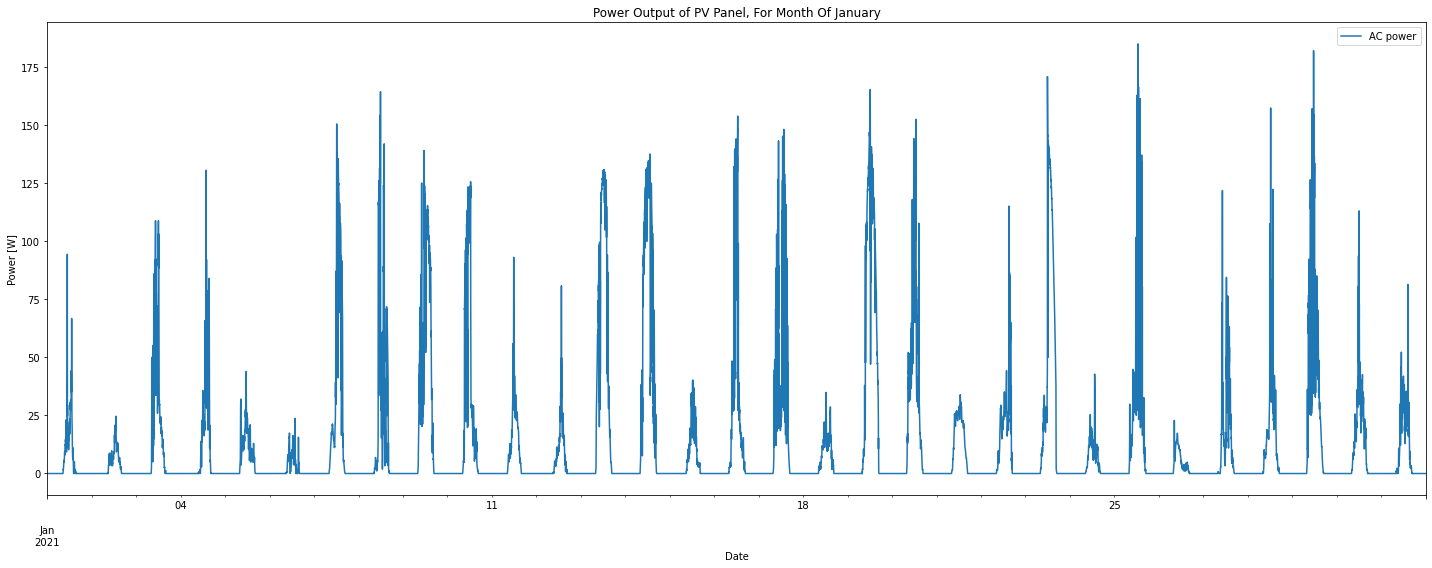

In [155]:
# Plot of Power Output 
fig, ax = plt.subplots(figsize=(20, 8))

#x=1.576*0.825*mc.results.weather['dhi']

#x.plot()
#mc.results.weather['dhi'].plot(label='irrad')
ax = mc.results.ac.plot(label='AC power')
#mc.results.dc['p_mp'].plot(label='DC power')
#ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))
ax.set_ylabel('Power [W]')
ax.set_xlabel('Date')
ax.set_title('Power Output of PV Panel, For Month Of January')
plt.legend()
plt.tight_layout()
plt.show() 

In [156]:
import numpy as np

ac_array = mc.results.ac.values

np.add.reduceat(ac_array, np.arange(0, len(ac_array), 15))

for i in range(len(ac_array)):
    if ac_array[i] < 0:
        ac_array[i] = 0
        
df = pd.DataFrame(ac_array, columns = ['Solar_output'])

df.to_csv(r'C:\Users\baron\OneDrive\Desktop\Capstone\Code\greenwaymicrogrid\AC_output.csv')
